In [1]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
from joblib import delayed, Parallel

import config.CONSTANTS_HMM as consts
import src.optimization_package.optimizer

In [2]:
importlib.reload(src.optimization_package.optimizer)
from src.optimization_package.optimizer import OptimizerPGPE
importlib.reload(consts)
from config.CONSTANTS_HMM import *

In [3]:
# Store constants
cm = {} # Constants Manager
for k, v in consts.__dict__.items():
    if not k.startswith('__'):
        cm[k] = v

In [4]:
uniform_initialization = {
    'tot_impressions': 5000,
    'num_campaigns': N_camp
}

policy = OptimizerPGPE(cm, num_sample=32, hmm_trials=10, N_users_to_simulate=5000, uniform_initialization=uniform_initialization)

In [5]:
budgets_list = []
convs_list = np.array([])
learning_rate = 1

history_return = []
history_variance = []

while True:
    budgets = policy.get_theta()
    returns = Parallel(n_jobs=2)(delayed(policy.act)(budget) for budget in budgets)

    print(returns)

    delta_params = np.array(policy.eval_gradient(budgets, returns, use_baseline=True))

    print('Budget distribution: ', policy.get_budget_distribution(),         'Return: ', policy.act(policy.get_budget_distribution()),
          'Variance: ', policy.variance)

    params = policy.get_params()
    policy.set_params(params + learning_rate*delta_params)

    learning_rate = max(0.95*learning_rate, 1e-3)
    #convs_list *= 0.99

    history_return.append(np.mean(returns))
    history_variance.append(policy.variance)

    if max(policy.variance) < 1e-4:
        break

2022-06-25 16:40:20.104317: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-25 16:40:20.106759: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[0.05442, 0.06716, 0.0656, 0.05534, 0.0857, 0.06118, 0.02502, 0.01106, 0.06748, 0.06898, 0.03536, 0.06104, 0.04038, 0.0539, 0.0694, 0.10026, 0.09442, 0.0343, 0.08218, 0.02226, 0.09764, 0.08588, 0.06148, 0.09822, 0.01674, 0.09246, 0.06144, 0.01008, 0.0376, 0.10336, 0.07142, 0.0923]


2022-06-25 16:41:22.937234: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Budget distribution:  [0.5 0.5] Return:  0.06694 Variance:  [0.66666667 0.66666667]
[0.02954, 0.0612, 0.06448, 0.08618, 0.0843, 0.08712, 0.07962, 0.06224, 0.0604, 0.09146, 0.04662, 0.03802, 0.00876, 0.02322, 0.0226, 0.10168, 0.09536, 0.02456, 0.09196, 0.02326, 0.0975, 0.06754, 0.0452, 0.02792, 0.09226, 0.04814, 0.00864, 0.02534, 0.05216, 0.05656, 0.02194, 0.0584]
Budget distribution:  [0.49569052 0.50430948] Return:  0.06714 Variance:  [0.43269833 0.41389859]
[0.0902, 0.08906, 0.06302, 0.09162, 0.09954, 0.03328, 0.09878, 0.10444, 0.10186, 0.0944, 0.09916, 0.04052, 0.10118, 0.02238, 0.0513, 0.0991, 0.09748, 0.0984, 0.10024, 0.10252, 0.03978, 0.08196, 0.09154, 0.089, 0.10082, 0.06264, 0.0941, 0.05276, 0.09848, 0.07778, 0.05426, 0.04326]
Budget distribution:  [0.45040451 0.54959549] Return:  0.07678 Variance:  [0.28884424 0.16607504]
[0.05704, 0.09146, 0.08014, 0.09816, 0.09112, 0.09142, 0.07126, 0.094, 0.09682, 0.08014, 0.07874, 0.06784, 0.08226, 0.09224, 0.08674, 0.06658, 0.08516, 0.102

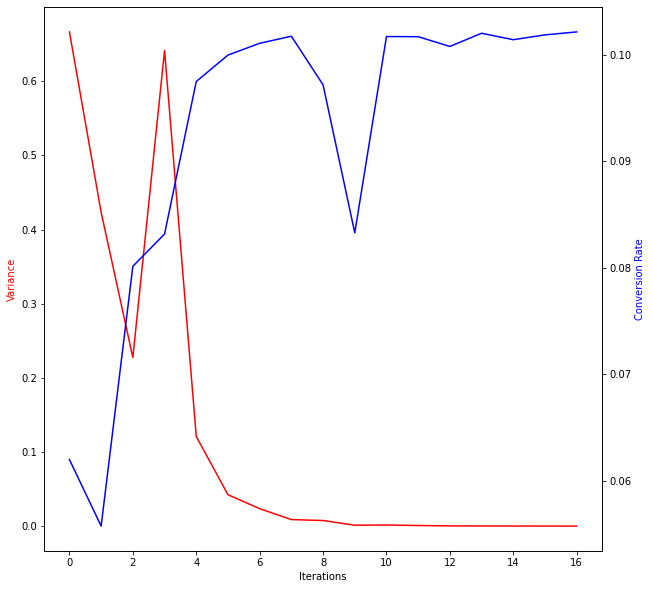

In [6]:
from matplotlib.ticker import MaxNLocator
import tikzplotlib as tkz

# Create Plot

fig, ax1 = plt.subplots(figsize=(10,10))

ax1.set_xlabel('Iterations')

ax1.set_ylabel('Variance', color = 'red')
ax1.plot([np.mean(var) for var in history_variance], color = 'red')

# Adding Twin Axes
ax2 = ax1.twinx()
ax2.plot(history_return, color = 'blue')

# Add label
plt.ylabel('Conversion Rate', color='blue')

# Show iterations as integers
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

# Save plot
tkz.save('/Users/Thom/OneDrive - Politecnico di Milano/Università/TESI/images/optimization_evolution_simple.tex')

In [7]:
x = []
y = []
for i in np.linspace(0,1,21):
    x.append(i)
    y.append(policy.act(np.array([1-i,i])))

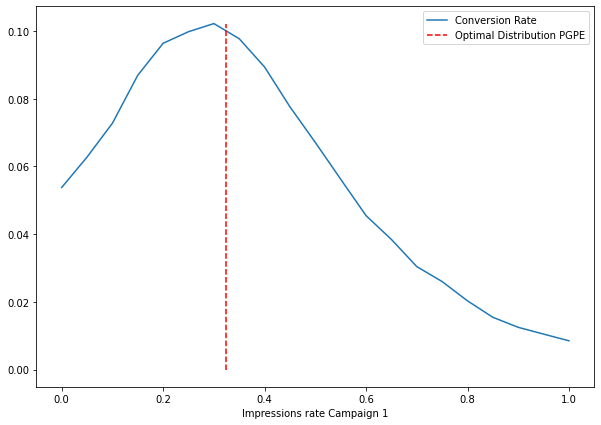

In [42]:
plt.subplots(figsize=(10,7))
plt.plot(x,y)
plt.plot([policy.get_budget_distribution()[0],policy.get_budget_distribution()[0]], [0, max(y)], 'r--')
plt.legend(['Conversion Rate','Optimal Distribution PGPE'])
plt.xlabel('Impressions rate Campaign 1')

tkz.save('/Users/Thom/OneDrive - Politecnico di Milano/Università/TESI/images/plot_conversion_rates.tex')

In [ ]:
from src.hmm_package.generate_hmm import make_transition_matrix
import tensorflow as tf
camp_1 = tf.concat([tf.Variable([[[0,0],[0,1]]], dtype=float), tf.zeros([1,2,29])], axis=2)
make_transition_matrix(cm, [ -4.75, -1.1, -5.9 ], [0.6, -0.3, 0.0, 0.0, -0.2, 0.15], tf.zeros([1,2,31]))